# Dataset Metadata

slo_fundus: image of SLO fundus
race: 0 - Asian, 1 - Black, 2 - White
male: 0 - Female, 1 - Male
hispanic: 0 - Non-Hispanic, 1 - Hispanic
dr_class: 0 or 1, representing class
    
**The mapping for non-Diabetic Retinopathy (class 0) and Diabetic Retinopathy (class 1):**

condition_disease_mapping = {'not.in.icd.table': 0.,
                    'no.dr.diagnosis': 0.,
                    'mild.npdr': 0.,
                    'moderate.npdr': 0.,
                    'severe.npdr': 1.,
                    'pdr': 1.}

You can use the above mapping to obtain the binary non-DR and DR labels based on the parameter "Diabetic Retinopathy Subtype". Or you can directly use "Diabetic Retinopathy Class" as the label which is consistent with above mapping outcome. 
For subgroup AUC, please refer to the Jupiter notebook in the class. You can find a reference paper here https://github.com/Harvard-Ophthalmology-AI-Lab/FairVision.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# For EfficientNet and ResNet models
from tensorflow.keras.applications import EfficientNetB0, ResNet50
import json
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_auc_score, accuracy_score

/home/C00579118/miniconda3/envs/jupy_env/lib/python3.6/site-packages/google/auth/crypt/_cryptography_rsa.py:22: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  import cryptography.exceptions


Keys in the .npz file: ['slo_fundus', 'race', 'male', 'hispanic', 'maritalstatus', 'language', 'dr_class', 'dr_subtype']
Race: 2
Male: 0
Hispanic: 0
Marital Status: 1
Language: 0
Diabetic Retinopathy Class: 0
Diabetic Retinopathy Subtype: no.dr.diagnosis


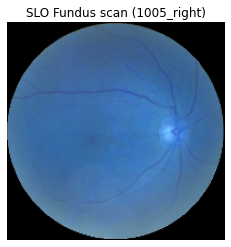

In [9]:
def load_npz_image(file_path):
    data = np.load(file_path)
    print("Keys in the .npz file:", data.files)
    slo_fundus = data['slo_fundus']  # Load the SLO fundus image

    # Access specific keys
    race = data['race']
    male = data['male']
    hispanic = data['hispanic']
    maritalstatus = data['maritalstatus']
    language = data['language']
    dr_class = data['dr_class']
    dr_subtype = data['dr_subtype']
    
    # Print fields
    print("Race:", race)
    print("Male:", male)
    print("Hispanic:", hispanic)
    print("Marital Status:", maritalstatus)
    print("Language:", language)
    print("Diabetic Retinopathy Class:", dr_class)
    print("Diabetic Retinopathy Subtype:", dr_subtype)
    return slo_fundus

# Load the file and extract the images
train_path = '/home/C00579118/Project-Code/Data Mining/Problem1_DiabeticRetin_ColorFundus/ODIR_Data/train/'
npz_file = os.path.join(train_path, '1005_right.npz')
slo_image = load_npz_image(npz_file)

# Visualize the SLO Fundus image
plt.imshow(slo_image, cmap='gray')
plt.title('SLO Fundus scan (1005_right)')
plt.axis('off')
plt.show()

In [10]:
import numpy as np

def load_npz_image(file_path):

    try:
        data = np.load(file_path)
        
        # Load images
        slo_fundus = data['slo_fundus']
        
        # Define required metadata fields
        required_fields = [
            'race', 'male', 'hispanic', 'maritalstatus', 
            'language', 'dr_class', 'dr_subtype'
        ]
        
        # Check if all required fields exist
        missing_fields = [field for field in required_fields if field not in data.files]
        if missing_fields:
            raise KeyError(f"Missing required fields in NPZ file: {missing_fields}")
            
        # Create metadata dictionary
        metadata = {
            'race': data['race'],
            'male': data['male'],
            'hispanic': data['hispanic'],
            'maritalstatus': data['maritalstatus'],
            'language': data['language'],
            'dr_class': data['dr_class'],
            'dr_subtype': data['dr_subtype']
        }
        
        # Print glaucoma status (can be removed if not needed)
#         print('dr_class: ', metadata['dr_class'])
        
        return slo_fundus, metadata
        
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find NPZ file at: {file_path}")
    except Exception as e:
        raise Exception(f"Error loading NPZ file: {str(e)}")

# Function to load all .npz files from a folder
def load_all_npz_files(folder_path):
    all_data = []
    data_img = []
    meta_data = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npz'):
            file_path = os.path.join(folder_path, file_name)
            slo_image, metadata = load_npz_image(file_path)
            all_data.append((slo_image, metadata))
            data_img.append(slo_image)
            meta_data.append(metadata)

    return all_data, data_img, meta_data

# Data path definition

In [11]:
# Define paths
train_path = '/home/C00579118/Project-Code/Data Mining/Problem1_DiabeticRetin_ColorFundus/ODIR_Data/train/'
valid_path = '/home/C00579118/Project-Code/Data Mining/Problem1_DiabeticRetin_ColorFundus/ODIR_Data/val/'
test_path = '/home/C00579118/Project-Code/Data Mining/Problem1_DiabeticRetin_ColorFundus/ODIR_Data/test/'

# Load all .npz files from the train and test folders
train_all, train_data, train_meta = load_all_npz_files(train_path)
valid_all, valid_data, valid_meta = load_all_npz_files(valid_path)
test_all, test_data, test_meta = load_all_npz_files(test_path)


In [12]:
print(np.asarray(train_data).shape)
print(np.asarray(train_meta).shape)
print(train_meta[0]['dr_class'])
print(train_meta[0])

(4476, 200, 200, 3)
(4476,)
0
{'race': array(2), 'male': array(1), 'hispanic': array(1), 'maritalstatus': array(4), 'language': array(2), 'dr_class': array(0), 'dr_subtype': array('no.dr.diagnosis', dtype='<U15')}


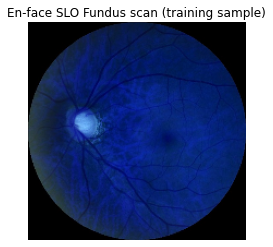

{'race': array(2), 'male': array(1), 'hispanic': array(1), 'maritalstatus': array(4), 'language': array(2), 'dr_class': array(0), 'dr_subtype': array('no.dr.diagnosis', dtype='<U15')}
(200, 200, 3)


In [13]:
def viz_image(slo_image, metadata):
    slo_image, metadata = train_data[0], train_meta[0]#['maritalstatus']  # First sample from training data
    plt.imshow(slo_image, cmap='gray')
    plt.title('En-face SLO Fundus scan (training sample)')
    plt.axis('off')
    plt.show()
    
    print(metadata)
    print(slo_image.shape)

    # Show the metadata of the first sample

viz_image(train_all[0], train_meta[0])

# Visualize Data Distribution

In [14]:
print('Train data: ',len(train_data),'Train image[0] shape: ', np.asarray(train_data).shape)
print('Valid data: ',len(valid_data),'Validation image[0] shape: ', np.asarray(valid_data).shape)
print('Test data: ',len(test_data),'Test image[0] shape: ', np.asarray(test_data).shape)

Train data:  4476 Train image[0] shape:  (4476, 200, 200, 3)
Valid data:  641 Validation image[0] shape:  (641, 200, 200, 3)
Test data:  1914 Test image[0] shape:  (1914, 200, 200, 3)


In [15]:
print(train_meta[0]['dr_class'])
print(np.asarray(train_data[0]).shape)

0
(200, 200, 3)


# Data Balance Check

In [16]:
from collections import Counter
import numpy as np

# Function to calculate class balance
def calculate_class_balance(data):
    overall_counts = Counter()
    attribute_counts = {attr: {} for attr in ['race', 'male', 'hispanic', 'maritalstatus', 'language']}
    
    for slo_image, metadata in data:
        dr_class = int(metadata['dr_class'])
        overall_counts[dr_class] += 1
        
        for attr in attribute_counts:
            attr_value = int(metadata[attr])
            if attr_value not in attribute_counts[attr]:
                attribute_counts[attr][attr_value] = Counter()
            attribute_counts[attr][attr_value][dr_class] += 1

    return overall_counts, attribute_counts

# Load and calculate class balances for each dataset
datasets = {'train_data': train_all, 'valid_data': valid_all, 'test_data': test_all}
class_balance_results = {}

for dataset_name, dataset in datasets.items():
    overall_counts, attribute_counts = calculate_class_balance(dataset)
    class_balance_results[dataset_name] = {'overall': overall_counts, 'by_attribute': attribute_counts}

# Print the results
for dataset_name, result in class_balance_results.items():
    print(f"\nClass Balance for {dataset_name}:\n")
    print("Overall Class Balance:", result['overall'])
    print("\nClass Balance by Attribute:\n")
    for attr, counts in result['by_attribute'].items():
        print(f"Attribute '{attr}':")
        for value, class_counts in counts.items():
            print(f"  Value {value}: {class_counts}")
        print()



Class Balance for train_data:

Overall Class Balance: Counter({0: 3358, 1: 1118})

Class Balance by Attribute:

Attribute 'race':
  Value 2: Counter({0: 1118, 1: 345})
  Value 1: Counter({0: 1157, 1: 388})
  Value 0: Counter({0: 1083, 1: 385})

Attribute 'male':
  Value 1: Counter({0: 1741, 1: 649})
  Value 0: Counter({0: 1617, 1: 469})

Attribute 'hispanic':
  Value 1: Counter({0: 1649, 1: 580})
  Value 0: Counter({0: 1709, 1: 538})

Attribute 'maritalstatus':
  Value 4: Counter({0: 695, 1: 217})
  Value 2: Counter({0: 657, 1: 232})
  Value 1: Counter({0: 682, 1: 225})
  Value 0: Counter({0: 617, 1: 223})
  Value 3: Counter({0: 707, 1: 221})

Attribute 'language':
  Value 2: Counter({0: 1113, 1: 386})
  Value 0: Counter({0: 1066, 1: 381})
  Value 1: Counter({0: 1179, 1: 351})


Class Balance for valid_data:

Overall Class Balance: Counter({0: 458, 1: 183})

Class Balance by Attribute:

Attribute 'race':
  Value 1: Counter({0: 163, 1: 55})
  Value 0: Counter({0: 141, 1: 64})
  Value 2

In [17]:
from collections import Counter
import numpy as np

# Example: Count occurrences for each demographic attribute
def calculate_distribution(train_meta, key):
    # Extract scalar values for the specified key
    values = [sample[key].item() if isinstance(sample[key], np.ndarray) else sample[key] for sample in train_meta]
    # Count occurrences
    distribution = Counter(values)
    return distribution

# Calculate distributions for each attribute
race_distribution = calculate_distribution(train_meta, 'race')
male_distribution = calculate_distribution(train_meta, 'male')
hispanic_distribution = calculate_distribution(train_meta, 'hispanic')
lang_distribution = calculate_distribution(train_meta, 'language')
marital_distribution = calculate_distribution(train_meta, 'maritalstatus')

print("Race Distribution:", race_distribution)
print("Male Distribution:", male_distribution)
print("Hispanic Distribution:", hispanic_distribution)
print("Language Distribution:", lang_distribution)
print("Maritalstatus Distribution:", marital_distribution)

Race Distribution: Counter({1: 1545, 0: 1468, 2: 1463})
Male Distribution: Counter({1: 2390, 0: 2086})
Hispanic Distribution: Counter({0: 2247, 1: 2229})
Language Distribution: Counter({1: 1530, 2: 1499, 0: 1447})
Maritalstatus Distribution: Counter({3: 928, 4: 912, 1: 907, 2: 889, 0: 840})


In [2]:
def load_and_preprocess_data(path):
    processed_images = []
    labels = []
    genders = []
    
    for filename in os.listdir(path):
        if filename.endswith('.npz'):
            data = np.load(os.path.join(path, filename))
            
            # Load image and preprocess
            image = data['slo_fundus']
            image = tf.image.resize(image, (224, 224))
            image = tf.keras.applications.efficientnet.preprocess_input(image)
            
            # Load labels and gender
            dr_class = data['dr_class']
            gender = data['male']
            
            processed_images.append(image)
            labels.append(dr_class)
            genders.append(gender)
    
    return np.array(processed_images), np.array(labels), np.array(genders)

class FairDataGenerator(tf.keras.utils.Sequence):
    """Custom data generator that yields (image, label, gender) tuples"""
    def __init__(self, images, labels, genders, batch_size=32, shuffle=True):
        self.images = images
        self.labels = labels
        self.genders = genders
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.images))
        batch_indexes = self.indexes[start_idx:end_idx]
        
        batch_images = self.images[batch_indexes]
        batch_labels = self.labels[batch_indexes]
        batch_genders = self.genders[batch_indexes]
        
        return batch_images, batch_labels, batch_genders

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
            

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from sklearn.metrics import roc_auc_score, accuracy_score
import os

class GroupMetric(tf.keras.metrics.Metric):
    """Custom metric to track group-specific performance"""
    def __init__(self, name='group_metric', **kwargs):
        super(GroupMetric, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, mask):
        y_true = tf.boolean_mask(y_true, mask)
        y_pred = tf.boolean_mask(y_pred, mask)
        
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.true_negatives.assign_add(tf.reduce_sum((1 - y_true) * (1 - y_pred)))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        numerator = self.true_positives
        denominator = self.true_positives + self.false_negatives + K.epsilon()
        return numerator / denominator

    def reset_state(self):
        self.true_positives.assign(0.)
        self.false_positives.assign(0.)
        self.true_negatives.assign(0.)
        self.false_negatives.assign(0.)

class FairModel(keras.Model):
    def __init__(self, model_type='efficientnet', fairness_weight=0.3):
        super(FairModel, self).__init__()
        # Create base model
        if model_type == 'efficientnet':
            self.base_model = EfficientNetB0(
                weights='imagenet',
                include_top=False,
                input_shape=(224, 224, 3)
            )
        else:
            self.base_model = ResNet50(
                weights='imagenet',
                include_top=False,
                input_shape=(224, 224, 3)
            )
        
        # Additional layers
        self.global_pool = keras.layers.GlobalAveragePooling2D()
        self.dropout = keras.layers.Dropout(0.3)
        self.dense1 = keras.layers.Dense(128, activation='relu')
        self.output_layer = keras.layers.Dense(1, activation='sigmoid')
        self.fairness_weight = fairness_weight
        
        # Group-specific metrics
        self.male_metric = GroupMetric(name='male_recall')
        self.female_metric = GroupMetric(name='female_recall')

    def call(self, inputs, training=False):
        x = self.base_model(inputs, training=training)
        x = self.global_pool(x)
        if training:
            x = self.dropout(x)
        x = self.dense1(x)
        return self.output_layer(x)

    def calculate_fairness_penalty(self, predictions, genders):
        """Calculate fairness penalty using demographic parity"""
        male_preds = tf.boolean_mask(predictions, tf.equal(genders, 1))
        female_preds = tf.boolean_mask(predictions, tf.equal(genders, 0))
        
        male_rate = tf.reduce_mean(tf.cast(male_preds > 0.5, tf.float32))
        female_rate = tf.reduce_mean(tf.cast(female_preds > 0.5, tf.float32))
        
        return tf.abs(male_rate - female_rate)

    def train_step(self, data):
        images, labels, genders = data
        labels = tf.cast(tf.reshape(labels, (-1, 1)), tf.float32)
        genders = tf.cast(tf.reshape(genders, (-1, 1)), tf.float32)
        
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            task_loss = self.compiled_loss(labels, predictions)
            fairness_penalty = self.calculate_fairness_penalty(predictions, genders)
            total_loss = task_loss + self.fairness_weight * fairness_penalty
        
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Update metrics
        self.compiled_metrics.update_state(labels, predictions)
        self.male_metric.update_state(labels, predictions, tf.equal(genders, 1))
        self.female_metric.update_state(labels, predictions, tf.equal(genders, 0))
        
        results = {m.name: m.result() for m in self.metrics}
        results.update({
            'fairness_penalty': fairness_penalty,
            'male_recall': self.male_metric.result(),
            'female_recall': self.female_metric.result()
        })
        return results

    def test_step(self, data):
        images, labels, genders = data
        labels = tf.cast(tf.reshape(labels, (-1, 1)), tf.float32)
        genders = tf.cast(tf.reshape(genders, (-1, 1)), tf.float32)
        
        predictions = self(images, training=False)
        
        # Update metrics
        self.compiled_metrics.update_state(labels, predictions)
        self.male_metric.update_state(labels, predictions, tf.equal(genders, 1))
        self.female_metric.update_state(labels, predictions, tf.equal(genders, 0))
        
        results = {m.name: m.result() for m in self.metrics}
        results.update({
            'male_recall': self.male_metric.result(),
            'female_recall': self.female_metric.result()
        })
        return results

def train_model(model_type='efficientnet', epochs=10):
    """Training function with improved progress monitoring"""
    # Load data
    print("Loading datasets...")
    train_data, train_labels, train_genders = load_and_preprocess_data(train_path)
    valid_data, valid_labels, valid_genders = load_and_preprocess_data(valid_path)
    test_data, test_labels, test_genders = load_and_preprocess_data(test_path)
    
    # Create data generators
    train_generator = FairDataGenerator(train_data, train_labels, train_genders, batch_size=32)
    valid_generator = FairDataGenerator(valid_data, valid_labels, valid_genders, batch_size=32)
    test_generator = FairDataGenerator(test_data, test_labels, test_genders, batch_size=32)
    
    # Create and compile model
    model = FairModel(model_type=model_type)
    
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.AUC(name='auc'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')
        ]
    )
    
    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=5,
            restore_best_weights=True,
            mode='max'
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            mode='max'
        ),
#         keras.callbacks.ModelCheckpoint(
# #             f'best_{model_type}_model.h5',
#             monitor='val_auc',
#             save_best_only=True,
#             mode='max'
#         )
    ]
    
    # Train model
    print(f"\nTraining {model_type} with fairness...")
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate model
    print("\nEvaluating model...")
    results = model.evaluate(test_generator, verbose=1)
    
    return model, history, results


# (Train|Valid|Test) set generation

In [4]:
# Load data
print("Loading datasets...")
train_data, train_labels, train_genders = load_and_preprocess_data(train_path)
valid_data, valid_labels, valid_genders = load_and_preprocess_data(valid_path)
test_data, test_labels, test_genders = load_and_preprocess_data(test_path)

# Create data generators
train_generator = FairDataGenerator(train_data, train_labels, train_genders, batch_size=32)
valid_generator = FairDataGenerator(valid_data, valid_labels, valid_genders, batch_size=32)
test_generator = FairDataGenerator(test_data, test_labels, test_genders, batch_size=32)

Loading datasets...


# Train EfficientNet

In [5]:
print("Training EfficientNet model...")
efficientnet_model, efficientnet_history, efficientnet_results = train_model('efficientnet')

Training EfficientNet model...
Loading datasets...

Training efficientnet with fairness...
Epoch 1/10
140/140 [==============================] - 167s 1s/step - loss: 0.5423 - accuracy: 0.7379 - auc: 0.6496 - male_recall: 0.1541 - female_recall: 0.1493 - fairness_penalty: 0.0750 - val_loss: 0.0000e+00 - val_accuracy: 0.7223 - val_auc: 0.6398 - val_male_recall: 0.0275 - val_female_recall: 0.0270
Epoch 2/10
140/140 [==============================] - 156s 1s/step - loss: 0.4301 - accuracy: 0.8063 - auc: 0.8185 - male_recall: 0.3760 - female_recall: 0.3881 - fairness_penalty: 0.1006 - val_loss: 0.0000e+00 - val_accuracy: 0.7535 - val_auc: 0.7080 - val_male_recall: 0.1468 - val_female_recall: 0.1486
Epoch 3/10
140/140 [==============================] - 155s 1s/step - loss: 0.3471 - accuracy: 0.8499 - auc: 0.8908 - male_recall: 0.5347 - female_recall: 0.5458 - fairness_penalty: 0.1071 - val_loss: 0.0000e+00 - val_accuracy: 0.7566 - val_auc: 0.7431 - val_male_recall: 0.3211 - val_female_recall

# Train ResNet

In [6]:
print("\nTraining ResNet model...")
resnet_model, resnet_history, resnet_results = train_model('resnet')


Training ResNet model...
Loading datasets...

Training resnet with fairness...
Epoch 1/10
140/140 [==============================] - 302s 2s/step - loss: 0.5235 - accuracy: 0.7603 - auc: 0.6901 - male_recall: 0.2065 - female_recall: 0.2516 - fairness_penalty: 0.0805 - val_loss: 0.0000e+00 - val_accuracy: 0.7207 - val_auc: 0.6480 - val_male_recall: 0.0367 - val_female_recall: 0.0000e+00
Epoch 2/10
140/140 [==============================] - 298s 2s/step - loss: 0.4113 - accuracy: 0.8206 - auc: 0.8295 - male_recall: 0.4515 - female_recall: 0.4606 - fairness_penalty: 0.0978 - val_loss: 0.0000e+00 - val_accuracy: 0.7317 - val_auc: 0.6799 - val_male_recall: 0.0734 - val_female_recall: 0.0541
Epoch 3/10
140/140 [==============================] - 296s 2s/step - loss: 0.3011 - accuracy: 0.8673 - auc: 0.9147 - male_recall: 0.6133 - female_recall: 0.6397 - fairness_penalty: 0.1197 - val_loss: 0.0000e+00 - val_accuracy: 0.7363 - val_auc: 0.6614 - val_male_recall: 0.2018 - val_female_recall: 0.175

# Plot History (Train|Validation) Loss, Accuracy

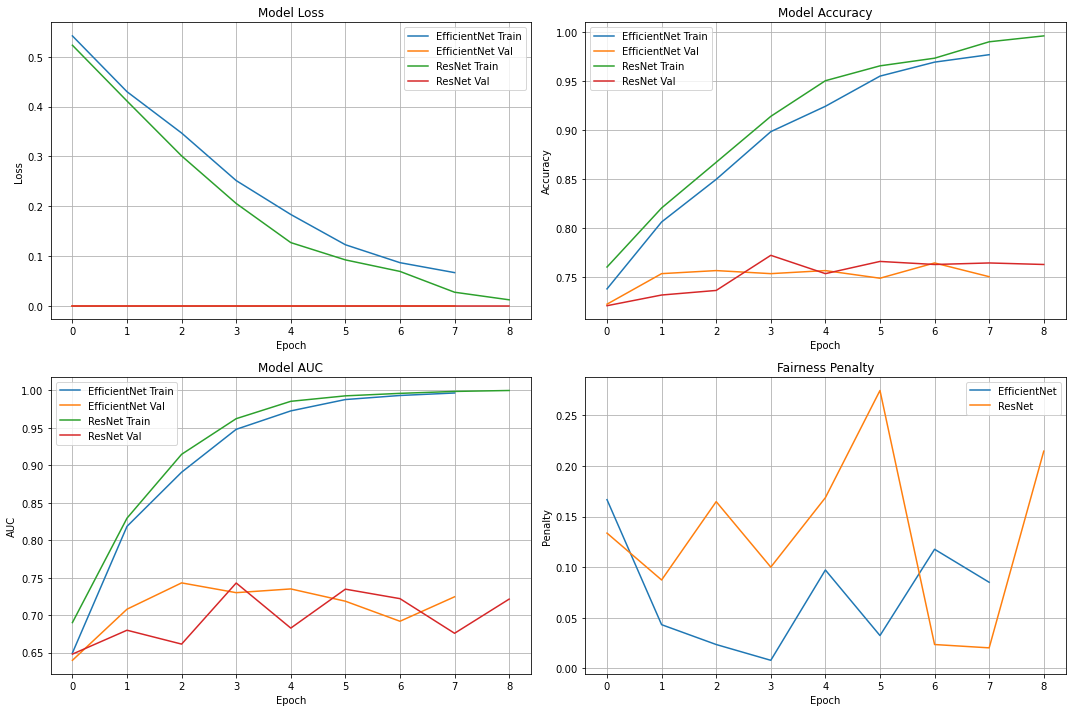


Final EfficientNet Results:
Test Loss: 0.0000
Test Accuracy: 0.7800
Test AUC: 0.7486

Final ResNet Results:
Test Loss: 0.0000
Test Accuracy: 0.7910
Test AUC: 0.7339


In [7]:
import matplotlib.pyplot as plt

def plot_training_history(efficientnet_history, resnet_history):
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation loss
    axes[0, 0].plot(efficientnet_history.history['loss'], label='EfficientNet Train')
    axes[0, 0].plot(efficientnet_history.history['val_loss'], label='EfficientNet Val')
    axes[0, 0].plot(resnet_history.history['loss'], label='ResNet Train')
    axes[0, 0].plot(resnet_history.history['val_loss'], label='ResNet Val')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot training & validation accuracy
    axes[0, 1].plot(efficientnet_history.history['accuracy'], label='EfficientNet Train')
    axes[0, 1].plot(efficientnet_history.history['val_accuracy'], label='EfficientNet Val')
    axes[0, 1].plot(resnet_history.history['accuracy'], label='ResNet Train')
    axes[0, 1].plot(resnet_history.history['val_accuracy'], label='ResNet Val')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot training & validation AUC
    axes[1, 0].plot(efficientnet_history.history['auc'], label='EfficientNet Train')
    axes[1, 0].plot(efficientnet_history.history['val_auc'], label='EfficientNet Val')
    axes[1, 0].plot(resnet_history.history['auc'], label='ResNet Train')
    axes[1, 0].plot(resnet_history.history['val_auc'], label='ResNet Val')
    axes[1, 0].set_title('Model AUC')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot fairness metrics
    axes[1, 1].plot(efficientnet_history.history['fairness_penalty'], label='EfficientNet')
    axes[1, 1].plot(resnet_history.history['fairness_penalty'], label='ResNet')
    axes[1, 1].set_title('Fairness Penalty')
    axes[1, 1].set_ylabel('Penalty')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()


# Then plot the training histories
plot_training_history(efficientnet_history, resnet_history)

# Print final metrics
print("\nFinal EfficientNet Results:")
print(f"Test Loss: {efficientnet_results[0]:.4f}")
print(f"Test Accuracy: {efficientnet_results[1]:.4f}")
print(f"Test AUC: {efficientnet_results[2]:.4f}")

print("\nFinal ResNet Results:")
print(f"Test Loss: {resnet_results[0]:.4f}")
print(f"Test Accuracy: {resnet_results[1]:.4f}")
print(f"Test AUC: {resnet_results[2]:.4f}")

# Print Group wise AUC

In [8]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

def calculate_group_metrics(model, test_generator):
    """
    Calculate accuracy and AUC scores for overall, male, and female groups
    """
    # Get predictions for all test data
    all_predictions = []
    all_labels = []
    all_genders = []
    
    for i in range(len(test_generator)):
        images, labels, genders = test_generator[i]
        predictions = model.predict(images, verbose=0)
        
        all_predictions.extend(predictions)
        all_labels.extend(labels)
        all_genders.extend(genders)
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_genders = np.array(all_genders)
    
    # Calculate binary predictions
    binary_predictions = (all_predictions > 0.5).astype(int)
    
    # Overall metrics
    overall_accuracy = accuracy_score(all_labels, binary_predictions)
    overall_auc = roc_auc_score(all_labels, all_predictions)
    
    # Male metrics
    male_mask = all_genders == 1
    male_accuracy = accuracy_score(all_labels[male_mask], binary_predictions[male_mask])
    male_auc = roc_auc_score(all_labels[male_mask], all_predictions[male_mask])
    
    # Female metrics
    female_mask = all_genders == 0
    female_accuracy = accuracy_score(all_labels[female_mask], binary_predictions[female_mask])
    female_auc = roc_auc_score(all_labels[female_mask], all_predictions[female_mask])
    
    print(f"Overall Group:")
    print(f"  Accuracy: {overall_accuracy:.3f}")
    print(f"  AUC: {overall_auc:.3f}")
    print(f"Male Group:")
    print(f"  Accuracy: {male_accuracy:.3f}")
    print(f"  AUC: {male_auc:.3f}")
    print(f"Female Group:")
    print(f"  Accuracy: {female_accuracy:.3f}")
    print(f"  AUC: {female_auc:.3f}")
    
    return {
        'overall': {'accuracy': overall_accuracy, 'auc': overall_auc},
        'male': {'accuracy': male_accuracy, 'auc': male_auc},
        'female': {'accuracy': female_accuracy, 'auc': female_auc}
    }

# After training the model
metrics = calculate_group_metrics(efficientnet_model, test_generator)

Overall Group:
  Accuracy: 0.780
  AUC: 0.749
Male Group:
  Accuracy: 0.782
  AUC: 0.764
Female Group:
  Accuracy: 0.777
  AUC: 0.733
